# Aufgabe 9

In [1]:
import numpy as np 
from scipy.integrate import quad
import matplotlib.pyplot as plt 
import pandas as pd
np.random.seed(42)

## a)

Es sollen mit Hilfe der Transformationsmethode Signalereignisse simuliert und gespeichert werden. Der Fluss der Neutrinos ist gegeben als

\begin{align*}
\Phi = \Phi_0 \cdot \left(\frac{E}{TeV}\right)^{-\gamma}.
\end{align*}

Diese Funktion soll nun transformiert werden. Dafür bestimmen wir erst einmal die Normierung.

\begin{align*}
A &= \int^{\infty}_{1} \Phi_0 \cdot E^{-\gamma}\; \text{d}E \\
  &= \Phi_0 \cdot \left[\frac{1}{1-\gamma} E^{-\gamma + 1} \right]_{1}^{\infty} \\
  &= \Phi_0 \cdot \frac{1}{\gamma -1} \\
\end{align*}

Nun wird die Funktion von $1$ bis $E$ integriert. 

\begin{align*}
A(E) &= \int^{E}_{1} \Phi_0 \cdot E^{-\gamma}\; \text{d}E \\
  &= \Phi_0 \cdot \left(- \frac{1}{\gamma -1}  \;E^{-\gamma + 1} + \frac{1}{\gamma -1}\right) \\
\end{align*}

Somit ergibt sich dann ein Gesamtergebnis von

\begin{align*}
\Phi\,(E) &= \frac{A(E)}{A} = \left(-E^{-\gamma + 1} + 1\right). \\
\end{align*}

Durch Invertieren ergibt sich dann 

\begin{align*}
E\,(\Phi) = \left(-\Phi + 1\right)^{\frac{1}{-\gamma + 1}}. \\
\end{align*}



In [2]:
def trafo(phi): #phi ist die Zufallsgröße, die Energiewerte werden zurückgegeben
    return (-phi+1)**(1/(1-2.7)) 

In [3]:
phi = np.random.uniform(0,1,10**5) #erzeugen von 10^5 Zufallszahlen zwischen 0 und 1
energie = trafo(phi) # Energiewerte

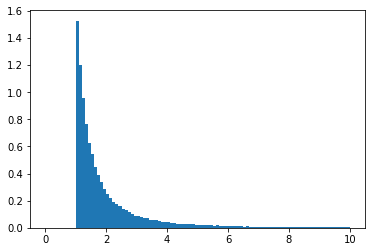

In [4]:
plt.hist(energie, bins= 100, range=[0,10], density=True) #Histogrammieren der Ausgabe
None

In [5]:
Signal = pd.DataFrame({ 
    'Energy': energie
}) # Speichern der Werte unter dem Key 'Energy'

## b)

Die Detektionswahrscheinlichkeit wird durch die Funktion `p(E)` beschrieben. Durch das Neumann'sche Rückweisungsverfahren wird die Detektorakzeptanz bestimmt und es wird eine Maske erstellt. Diese wird auch in dem Signal Dataframe abgespeichert. Die neuen Energiewerte, also für die `True` gilt, werden in einem Plot gegen die ursprüngliche Energie doppelt logarithmisch aufgetragen.

In [6]:
def p(E): #Detektionswahrscheinlichkeit
    return (1-np.exp(-E/2))**3

In [7]:
def neumann(ver_neu, energie, func): #Neumann Verfahren in einfacher Art und Weise
    return (func(energie) >= ver_neu)

In [8]:
ver_neu = np.random.normal(0,1,10**5) #Neue Verteilung
truefalseMaske = neumann(ver_neu, energie, p) #Vergleich zwischen neuer Verteilung und der Energie, damit erzeugen der True False Maske

In [9]:
Signal["AcceptanceMask"]= pd.Series(truefalseMaske) #Speichern der Maske

In [10]:
energie_neu = energie[truefalseMaske == True] #Sortieren der Energie

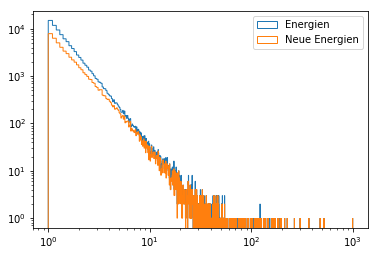

In [11]:
#Plotten der kompletten Energiewerte und der Aussortierten Werte
plt.hist(energie, bins= 10000, density=False, label="Energien", histtype="step")
plt.hist(energie_neu, bins= 10000, density=False, label="Neue Energien", histtype="step")
plt.legend(loc="best")
plt.xscale("log")
plt.yscale("log")

## c)

Mit der Polarmethode werden hier normalverteilte Zufallszahlen erstellt und genutzt um die Anzahl der Hits zu simulieren. Dafür wurden einige Bedingungen gegeben. Anschließend werden diese auch in der hdf5-Datei abgespeichert.

In [12]:
def polar(): #Erzeugen der s, v1 und v2 der Polarmethode
    verteilung1, verteilung2 = np.random.uniform(0,1,1), np.random.uniform(0,1,1)
    v1, v2 = 2*verteilung1-1, 2*verteilung2-1
    s = v1**2 + v2**2 
    return np.array([s, v1, v2])

In [13]:
def polarmethode(E): #Nutzen der Polarmethode zur Erzeugung der Hits
    x=[]
    i=0
    while len(x) < len(E):
        s, v1, v2 = polar()
        while (s >= 1 or s==0):
            s, v1, v2 = polar()
        x = np.append(x, np.sqrt(2*E[i]) * v1* np.sqrt(-2/s *np.log(s)) + 10*E[i])
        x = np.append(x, np.sqrt(2*E[i+1]) * v2* np.sqrt(-2/s *np.log(s)) + 10*E[i+1])
        i+=2 
    return x

In [14]:
hits = np.round(polarmethode(energie), 0) #Erzeugung der Hits

In [15]:
Signal["NumberOfHits"]= pd.Series(hits) #Speichern der Number of hits

## d) 

In diesem Aufgabenteil werden die Orte simuliert. Das Signal soll am Punkt (7,3) auftreffen und es gibt wieder einige Bedingungen an die Verteilungen, die erfüllt werden mussten. Die Orte werden als Keys `x` und `y` in der hdf5-Datei gespeichert.

In [16]:
def ort(numbofhits): # Orte der Hits werden simuliert, normalverteilt
    sigma = 1/np.log10(numbofhits+1)
    x, y = [], []
    for i in range(len(numbofhits)):
        a, b = np.random.normal(7,sigma[i], 1), np.random.normal(3, sigma[i], 1)
        while(a<0 or a>10):
            a = np.random.normal(7,sigma[i], 1)
        while(b<0 or b>10):
            b = np.random.normal(3,sigma[i], 1)
        x = np.append(x, a)
        y = np.append(y, b)
    return [x, y]

In [17]:
x, y = ort(hits)
Signal["x"]= pd.Series(x) #Speichern der Orte
Signal["y"]= pd.Series(y)
Signal.to_hdf('NeutrinoMC.hdf5', key='Signal') #Speichern des Signal Keys in der hdf5 Datei
Signal.head() #Überprüfen, ob das Dataframe wie erwünscht erzeugt wurde

,Energy,AcceptanceMask,NumberOfHits,x,y
0,1.317901,False,12.0,7.639109,4.392470
1,5.874727,False,66.0,7.187508,3.541687
2,2.169629,True,21.0,6.146962,3.280138
3,1.710909,True,16.0,6.299710,1.763099
4,1.104927,False,12.0,7.362339,4.467621


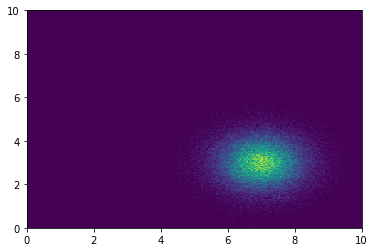

In [18]:
plt.hist2d(x, y, bins=[200, 200], range=[[0,10],[0,10]]) #Histogrammieren des Signals
None

## e)  

In diesem Teil soll ein Untergrundsignal, also das Background Signal, simuliert werden. Wir haben eine Funktion `ort2` geschrieben, die den Auftreffort der Background-Hits simuliert. 
Anschließend werden die Ergebnisse gespeichert und geplottet. 

In [19]:
def ort2(sigma, mean, rho, N): #Std, Erwartungswert, Korrelation und Anzahl der zu erzeugenden Verteilung
    x = []
    y = []
    numb = N
    while len(x) < N: 
        a = np.random.normal(0,1,numb)
        b = np.random.normal(0,1,numb)
        a1 = np.sqrt(1-rho**2)*sigma*a + sigma*rho*b + mean 
        b1 = sigma*b + mean
        anew = a1[(a1>0) & (a1<10) & (b1>0) & (b1<10)]
        bnew = b1[(a1>0) & (a1<10) & (b1>0) & (b1<10)]
        x = np.append(x,anew)
        y = np.append(y,bnew)
        numb = N - len(x)
    return x,y

In [20]:
hitslog = np.random.normal(2,1, 10**7) #Erzeugen der Number of Hits
sigma = 3
mean = 5 
rho = 0.5 
x, y = ort2(sigma, mean, rho, 10**7) #Bestimmen der Orte der Hits

Background = pd.DataFrame({ #Speichern des simulierten Backgrounds
    'NumberOfHits': 10**hitslog,
    'x': x,
    'y': y
})
Background.to_hdf('NeutrinoMC.hdf5', key='Background') #Speichern des Backgrounds
Background.head() #Überprüfen des Dataframes

,NumberOfHits,x,y
0,3618.224653,5.309172,6.295502
1,462.891615,1.252455,3.323755
2,6.804803,4.600938,6.722030
3,153.052385,9.101244,9.483938
4,56.608049,5.092038,2.310332


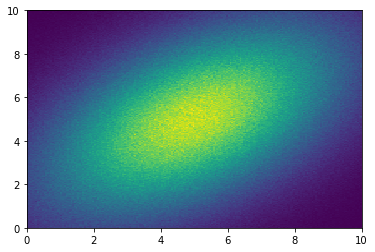

In [21]:
plt.hist2d(x, y, bins=[200, 200], range=[[0,10],[0,10]]) #Histogrammieren des Backgrounds
None

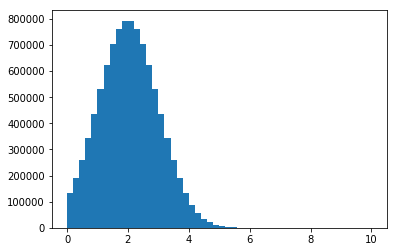

In [22]:
plt.hist(hitslog, range=(0,10), bins=50) #Histogrammieren der 10er logarithmierten Number of Hits 
None

# Aufgabe 10

## Teilaufgabe a)

Der Metropolis-Hastings-Algorithmus für Zufallszahlen, die der Verteilung der Funktion $f(x)$ folgen sollen, hat die Übergangswahrscheinlichkeit 

$$ M_{i\rightarrow j} = \text{min}\left(1, \frac{f\left(x_j\right)}{f\left(x_i\right)} \frac{g\left(x_j \vert x_i\right)}{g\left(x_i \vert x_j \right)}\right)\,.$$

Dabei ist $x_i$ eine generierte Zufallszahl und $x_j$ eine vorgeschlagene Zufallszahl, die bei Annahme an die zu generierende Folge angehängt wird. Der vorgeschlagene Wert wird akzeptiert, wenn $M_{i\rightarrow j}$ größer oder gleich einer zufällig auf dem Intervall von null bis eins gewählten Zahl ist. Die Funktion $g$ ist eine Schrittvorschlags-PDF. Der Ausdruck $g\left(x_i \vert x_j \right)$ beschreibt die Übergangswahrscheinlichkeit aus dem Zustand $x_i$ in den Zustand $x_j$.

Für eine Gaußverteilung gilt 

$$g\left(x_i|x_j\right) = N \cdot \exp(-(x_i-x_j)^2)\,.$$

$\mu$ ist der Erwartungswert der Gaußverteilung. Da die Gaußverteilung symmetrisch ist, gilt dann auch

$$g\left(x_j|x_i\right) = N \cdot \exp(-(x_j-x_i)^2 = g\left(x_i|x_j\right)\,.$$

Damit wird der zweite Bruch in der Übergangswahrscheinlichkeit 1 und es bleibt für die Übergangswahrscheinlichkeit der Ausdruck 

$$ M_{i\rightarrow j} = \text{min}\left(1, \frac{f\left(x_j\right)}{f\left(x_i\right)}\right)\,.$$ 

Das entspricht genau der Übergangswahrscheinlichkeit vom Metropolis Algorithmus.


## b)

Der Metropolis Algorithmus aus der Vorlesung wird im folgenden programmiert. Im Hinblick auf die c) geben wir ein Array x ein, die Schrittweite s und eine Verteilungsfunktion f.

In [23]:
def metropolis(x, s, f): #Verteilung x, Step Size s und Verteilungsfunktion f
    if (x[-1]-s < 0):
        xj = np.random.uniform(0, x[-1]+s, 1)
    else:
        xj = np.random.uniform(x[-1]-s, x[-1]+s, 1)
    Mij = np.min([1, f(xj)/f(x[-1])])
    eta = np.random.uniform(0, 1, 1)
    if eta <= Mij:
        c = xj
    else: 
        c = x[-1]
    return c

## c)

Der Metropolis Algorithmus bestimmt nun eine Planckverteilung im folgenden Beispiel. Anschließend werden die Funktion und die Verteilung geplottet und das Ergebnis zeigt, dass die beiden gut zueinander passen.

In [24]:
def planck(x): #Beispiel Verteilung
    return x**3/(np.exp(x) - 1)

In [25]:
N = 1/quad(planck,0, np.inf)[0] #Normierung der Planckverteilung

In [26]:
def planck_norm(x): #normierte Verteilung 
    return N* x**3/(np.exp(x) -1)

In [27]:
planckverteilung = np.array([30]) #Array das zu füllen ist
for i in range(10**5-1): #For Loop zum Füllen des Arrays mit Metropolis Algorithmus
    planckverteilung = np.append(planckverteilung, metropolis(planckverteilung, 2, planck_norm))

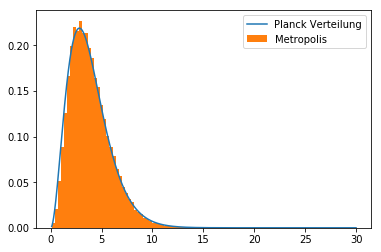

In [28]:
x = np.linspace(0.1,30, 10**5) #x-Werte der Verteilung
plt.plot(x, planck_norm(x), label="Planck Verteilung") #Plotten der Verteilung
plt.hist(planckverteilung, bins= 100, density=True, label="Metropolis") #Histogrammieren der Verteilung nach Metropolis Algorithmus
plt.legend()
None

## d)

Es wird ein Traceplot erstellt. Dieser zeigt, dass die erzeugten Werte bei den verschiedenen Iterationen um das Maximum der Planckverteilung, also ca. um den Wert 5 herum oszillieren, was im Zusammenhang mit der Verteilung, die ein Maximum ca. beim Wert 5 hat, auch Sinn ergibt.

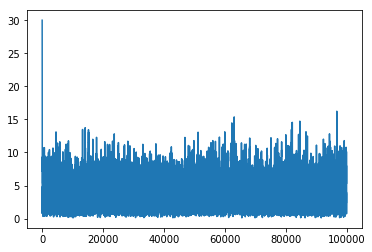

In [29]:
#Trace Plot

iteration = np.arange(10**5) # Nummer der Iteration der erzeugten Werte 
plt.plot(iteration, planckverteilung); #Iteration gegen erzeugten Wert aufgetragen